## GMM

### K-Means의 문제점
: 오른쪽 그래프를 보면 빨간 동그라미처럼 군집화 해야 하는 경우로, 중심점으로 부터 거리기반인 K-Means로는 군집화 어렵다.<br>
<img src=https://blog.kakaocdn.net/dn/3chpW/btrFEZHJa2k/L0THxMN8NPoKbLpO5hVIM1/img.png width=1000>

### GMM 개요
: GMM 군집화는 데이터가 여러개의 다른 가우시안 분포를 가지는 모델이라고 가정하고 군집화 수행<br>

<img src=https://blog.kakaocdn.net/dn/bDlZSN/btrFFPxwwMc/kLllpGmxIRgwWuEaBCLWu1/img.png width=1000>

즉, 군집화하려는 데이터 분포가 평균과 표준편차가 다른 여러 정규분포로 결합된 분포로 가정.<br>
-> 이런 개별 정규분포들을 찾아야 한다.<br>
> -> 이런 개별 정규분포들을 찾으려면 GMM 모수 추정을 해야한다.<br>

<img src=https://blog.kakaocdn.net/dn/PN6vb/btrFGAfzb6z/mTNHTDFf0qKbWPN9rC2XHK/img.png width=1000>

### GMM 모수 추정
: 개별 정규 분포들의 평균과 분산, 그리고 데이터가 특정 정규 분포에 해당 될 확률을 추정하는 것.<br>
<img src=https://blog.kakaocdn.net/dn/2LlAn/btrFGlW8R3x/qBGddkEYWlJkeKRIgUTeB0/img.png width=1000>

### EM 방식
: 개별 정규분포의 평균과 분산이 더이상 변경되지 않을 떄 까지, E와 M을 반복 수행
<br>
1. Expectation: 개별 데이터 각각에 대해 특정 정규 분포에 소속될 확률을 구하고, 가장 높은 확률을 가진 정규 분포에 소속을 시키는 것.
2. Maximization: 위에서 데이터가 이동하였으니, 각 정규 분포별로 평균과 분산을 다시 계산.
-> 데이터들의 정규 분포 소속이 더 이상 변경되지 않을 때 까지, E와 M을 계속 반복
<br>
<img src=https://blog.kakaocdn.net/dn/l5XAY/btrFEWLdjeQ/rIwEZ9xx4JSoPDZ5EDLVP0/img.png width=1000>

## GMM 을 이용한 붓꽃 데이터 셋 클러스터링

### 사이킷런 GMM 개요
<img src=https://blog.kakaocdn.net/dn/dTPECB/btrFFhVJKH9/fF5JUitZrC7KPh9oIdAF00/img.png width=1000>

In [3]:
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

iris = load_iris()
feature_names = ['sepal_length','sepal_width','petal_length','petal_width']

# 보다 편리한 데이타 Handling을 위해 DataFrame으로 변환
irisDF = pd.DataFrame(data=iris.data, columns=feature_names)
irisDF['target'] = iris.target
irisDF.head(3)

,sepal_length,sepal_width,petal_length,petal_width,target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0


### **GaussianMixture를 이용하여 붓꽃 데이터 군집화**

In [4]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, random_state=0).fit(iris.data)
gmm_cluster_labels = gmm.predict(iris.data)

# 클러스터링 결과를 irisDF 의 'gmm_cluster' 컬럼명으로 저장
irisDF['gmm_cluster'] = gmm_cluster_labels


# target 값에 따라서 gmm_cluster 값이 어떻게 매핑되었는지 확인. 
iris_result = irisDF.groupby(['target'])['gmm_cluster'].value_counts()
print(iris_result)

target  gmm_cluster
0       0              50
1       2              45
        1               5
2       1              50
Name: gmm_cluster, dtype: int64


### **붓꽃 데이터 K-Means 군집화 결과와 비교**

In [6]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300,random_state=0).fit(iris.data)
kmeans_cluster_labels = kmeans.predict(iris.data)
irisDF['kmeans_cluster'] = kmeans_cluster_labels
iris_result = irisDF.groupby(['target'])['kmeans_cluster'].value_counts()
print(f"target: {iris.target_names}")
print(iris_result)

target: ['setosa' 'versicolor' 'virginica']
target  kmeans_cluster
0       1                 50
1       0                 48
        2                  2
2       2                 36
        0                 14
Name: kmeans_cluster, dtype: int64


### **클러스터링 결과를 시각화하는 함수 생성**

In [23]:
### 클러스터 결과를 담은 DataFrame과 사이킷런의 Cluster 객체등을 인자로 받아 클러스터링 결과를 시각화하는 함수  
def visualize_cluster_plot(clusterobj, dataframe, label_name, iscenter=True):
    if iscenter :
        centers = clusterobj.cluster_centers_
        
    unique_labels = np.unique(dataframe[label_name].values)
    markers=['o', 's', '^', 'x', '*']
    isNoise=False

    for label in unique_labels:
        label_cluster = dataframe[dataframe[label_name]==label]
        if label == -1:
            cluster_legend = 'Noise'
            isNoise=True
        else :
            cluster_legend = 'Cluster '+str(label)
        
        plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], s=70,\
                    edgecolor='k', marker=markers[label], label=cluster_legend)
        
        if iscenter:
            center_x_y = centers[label]
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=700, color='white',
                        alpha=0.9, edgecolor='k', marker=markers[label])
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k',\
                        edgecolor='k', marker='$%d$' % label)
    if isNoise:
        legend_loc='upper center'
    else: legend_loc='upper right'
    
    plt.legend(loc=legend_loc)
    plt.show()

### 타원형 임의 데이터셋 생성
**GMM군집화와 K-Means군집화를 비교하기 위해 타원형으로 늘어선 임의의 데이터 세트를 생성**

In [18]:
from sklearn.datasets import make_blobs

# make_blobs() 로 300개의 데이터 셋, 3개의 cluster 셋, cluster_std=0.5 을 만듬. 
X, y = make_blobs(n_samples=300, n_features=2, centers=3, cluster_std=0.5, random_state=0)

# 길게 늘어난 타원형의 데이터 셋을 생성하기 위해 변환함. 
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)
# feature 데이터 셋과 make_blobs( ) 의 y 결과 값을 DataFrame으로 저장
clusterDF = pd.DataFrame(data=X_aniso, columns=['ftr1', 'ftr2'])
clusterDF['target'] = y

In [19]:
## 그래프 스타일 설정
plt.rcParams['xtick.color'] = 'white';plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.color'] = 'white';plt.rcParams['ytick.labelsize']=15
plt.rcParams['axes.labelcolor'] = 'white';plt.rcParams['axes.labelsize']= 17
plt.rcParams['axes.titlecolor']= 'white';plt.rcParams['axes.titlesize']= 20
plt.rcParams['figure.figsize'] = (10,6)

In [20]:
clusterDF.head(3)

,ftr1,ftr2,target
0,-1.671828,3.814284,0
1,0.945385,-0.901944,1
2,-0.959199,2.857152,0


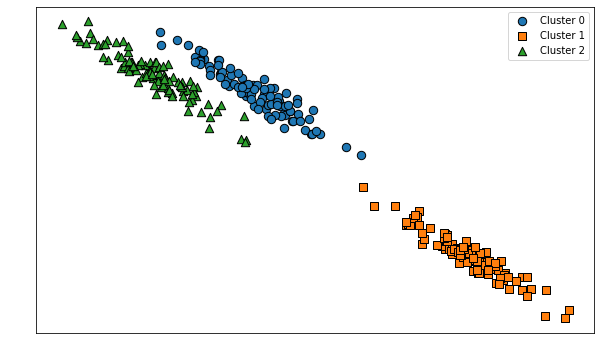

In [21]:
# 생성된 데이터 셋을 target 별로 다른 marker 로 표시하여 시각화 함. 
# clusterDF를 타겟별로 시각화
visualize_cluster_plot(None, clusterDF, 'target', iscenter=False)

### **K-Means 군집화 수행**

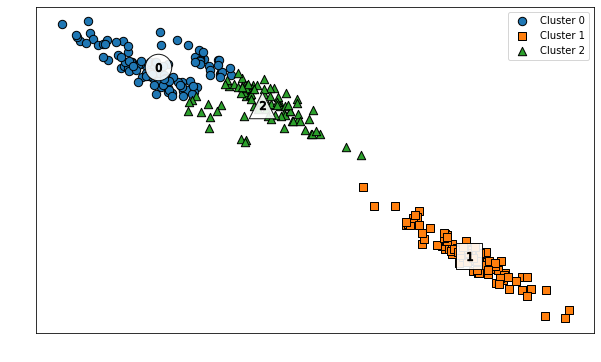

In [24]:
# 3개의 Cluster 기반 Kmeans 를 X_aniso 데이터 셋에 적용 
kmeans = KMeans(3, random_state=0)
kmeans_label = kmeans.fit_predict(X_aniso)
clusterDF['kmeans_label'] = kmeans_label

visualize_cluster_plot(kmeans, clusterDF, 'kmeans_label', iscenter=True)

### **GMM 군집화 수행**

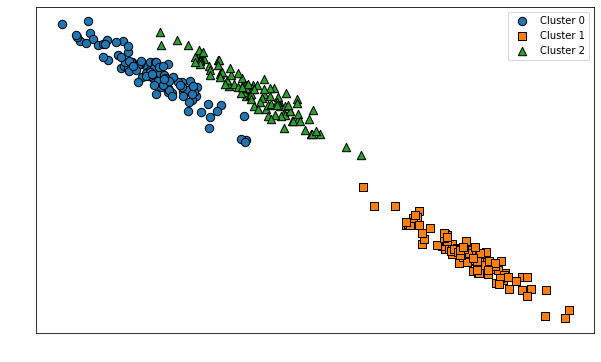

In [25]:
# 3개의 n_components기반 GMM을 X_aniso 데이터 셋에 적용 
gmm = GaussianMixture(n_components=3, random_state=0)
gmm_label = gmm.fit(X_aniso).predict(X_aniso)
clusterDF['gmm_label'] = gmm_label

# GaussianMixture는 cluster_centers_ 속성이 없으므로 iscenter를 False로 설정. 
visualize_cluster_plot(gmm, clusterDF, 'gmm_label',iscenter=False)
# K-Means와 달리 파란색, 초록색, 주황색이 잘 군집화된 것을 확인할 수 있다.

**GMM과 K-Means 군집화 결과 비교**

In [26]:
clusterDF.head(3)

,ftr1,ftr2,target,kmeans_label,gmm_label
0,-1.671828,3.814284,0,0,2
1,0.945385,-0.901944,1,1,1
2,-0.959199,2.857152,0,2,2


In [10]:
print('### KMeans Clustering ###')
print(clusterDF.groupby('target')['kmeans_label'].value_counts())
print('\n### Gaussian Mixture Clustering ###')
print(clusterDF.groupby('target')['gmm_label'].value_counts())
# 타겟별로 kmeans 결과와 GMM 결과에 대해 value_counts()출력

### KMeans Clustering ###
target  kmeans_label
0       2                73
        0                27
1       1               100
2       0                86
        2                14
Name: kmeans_label, dtype: int64

### Gaussian Mixture Clustering ###
target  gmm_label
0       2            100
1       1            100
2       0            100
Name: gmm_label, dtype: int64
